In [1]:
import numpy as np
import os
import sys
import pandas as pd
import seaborn as sns

import pylab as pl
import h5py

import tensorflow as tf
from tensorflow.keras import mixed_precision

os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
os.environ['CUDA_VISIBLE_DEVICES']="0" 

gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)


from sklearn.metrics import confusion_matrix

base_dir = '/media/tord/T7/Thesis_ssd/MasterThesis3'
os.chdir(base_dir)
from Classes.DataProcessing.LoadData import LoadData
from Classes.DataProcessing.HelperFunctions import HelperFunctions
from Classes.DataProcessing.DataHandler import DataHandler
from Classes.Modeling.DynamicModels import DynamicModels
from Classes.Modeling.TrainSingleModelRam import TrainSingleModelRam
from Classes.DataProcessing.RamLoader import RamLoader
import json

import gc

import datetime
import re
from livelossplot import PlotLossesKeras
from GlobalUtils import GlobalUtils
from Classes.Modeling.CustomCallback import CustomCallback
from tensorflow.keras.callbacks import EarlyStopping
utils = GlobalUtils()

from tensorflow.keras.utils import GeneratorEnqueuer






import sys


helper = HelperFunctions()

tf.config.optimizer.set_jit(True)
mixed_precision.set_global_policy('mixed_float16')

1 Physical GPUs, 1 Logical GPUs

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: GeForce RTX 3090, compute capability 8.6


In [2]:
load_args = {
    'earth_explo_only' : True,
    'noise_earth_only' : False,
    'noise_not_noise' : False,
    'downsample' : True,
    'upsample' : True,
    'frac_diff' : 1,
    'seed' : 1,
    'subsample_size' : 0.25,
    'balance_non_train_set' : False,
    'use_true_test_set' : False,
    'even_balance' : True
}
loadData = LoadData(**load_args)
train_ds, val_ds, test_ds = loadData.get_datasets()
noise_ds = loadData.noise_ds
handler = DataHandler(loadData)

2 2
Mapping train redundancy: : [--------------------------------------->] 100 %

Mapping validation redundancy: : [--------------------------------------->] 100 %

Mapping test redundancy: : [--------------------------------------->] 100 %



Loaded explosion and earthquake dataset:
Evenly balanced among classes in the train set.
Distribution (Label: (counts, proportion)) of
Train ds:
earthquake: (20507, 0.4987)  |  explosion: (20616, 0.5013)  
Val ds:
earthquake: (255, 0.0762)  |  explosion: (3092, 0.9238)  
Test ds:
earthquake: (176, 0.0789)  |  explosion: (2055, 0.9211)  


In [3]:
model_type = "DENSE_grow"
is_lstm = True
num_channels = 3    

use_time_augmentor = True
scaler_name = "standard"
use_noise_augmentor = True
filter_name = None
band_min = 2.0
band_max = 4.0
highpass_freq = 0.075


shutdown = False

num_classes = len(list(set(loadData.label_dict.values())))



ramLoader = RamLoader(loadData, 
                      handler, 
                      use_time_augmentor = use_time_augmentor, 
                      use_noise_augmentor = use_noise_augmentor, 
                      scaler_name = scaler_name,
                      filter_name = filter_name, 
                      band_min = band_min,
                      band_max = band_max,
                      highpass_freq = highpass_freq, 
                      load_test_set = True, 
                      meier_load = False)

x_train, y_train, x_val, y_val, x_test, y_test, noiseAug = ramLoader.load_to_ram()



Fitting noise set time augmentor: [--------------------------------------->] 100 %

Fit process completed after 9.943263292312622 seconds. Total datapoints fitted: 21199.
Average time per datapoint: 0.0004690439781269221


Fitting train time augmentor: [--------------------------------------->] 100 %

Fit process completed after 13.701163053512573 seconds. Total datapoints fitted: 41123.
Average time per datapoint: 0.0003331751830730388


Fitting validation time augmentor: [--------------------------------------->] 100 %

Fit process completed after 1.6093463897705078 seconds. Total datapoints fitted: 3347.
Average time per datapoint: 0.00048083250366612123


Fitting test time augmentor: [--------------------------------------->] 100 %

Fit process completed after 1.0685522556304932 seconds. Total datapoints fitted: 2231.
Average time per datapoint: 0.0004789566363202569


Stage one loading training set, timeAug: [--------------------------------------->] 100 %

Stage one loading valid

# Final EE model:

Trying to create result file
Made result file:  results_DENSE_grow_earthExplo_timeAug_standard_noiseAug_earlyS_unbalanced_valtest_subsample-0.25_numChannels-3_f2.csv
[   {'model_type': 'DENSE_grow'},
    {   'activation': 'relu',
        'batch_size': 256,
        'dropout_T_bn_F': False,
        'dropout_rate': 0.001,
        'epochs': 50,
        'growth_sequence': [1, 2],
        'l1_r': 0,
        'l2_r': 0.001,
        'learning_rate': 0.01,
        'num_layers': 2,
        'optimizer': 'sgd',
        'output_layer_activation': 'sigmoid',
        'units': 320,
        'use_layerwise_dropout_batchnorm': True}]
Saving file. 6 rows.
results_DENSE_grow_earthExplo_timeAug_standard_noiseAug_earlyS_unbalanced_valtest_subsample-0.25_numChannels-3_f2.csv saved to path:   /media/tord/T7/Thesis_ssd/MasterThesis3/GridSearchResults/2_classes
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1

160/160 [==============================] - 18s 110ms/step - loss: 1.5207 - precision: 0.8798 - recall: 0.8613 - binary_accuracy: 0.8715 - val_loss: 2.1038 - val_precision: 0.1205 - val_recall: 0.6511 - val_binary_accuracy: 0.6130
- val_f2: 0.3507
Epoch 23/50
160/160 [==============================] - 18s 109ms/step - loss: 1.5218 - precision: 0.8750 - recall: 0.8577 - binary_accuracy: 0.8683 - val_loss: 2.1181 - val_precision: 0.1140 - val_recall: 0.7003 - val_binary_accuracy: 0.5652
- val_f2: 0.3373

Epoch 00023: ReduceLROnPlateau reducing learning rate to 0.000312499993015.
Epoch 24/50
160/160 [==============================] - 17s 109ms/step - loss: 1.5190 - precision: 0.8798 - recall: 0.8624 - binary_accuracy: 0.8731 - val_loss: 2.1136 - val_precision: 0.1153 - val_recall: 0.7254 - val_binary_accuracy: 0.5598
- val_f2: 0.3402
Epoch 25/50
160/160 [==============================] - 18s 110ms/step - loss: 1.5192 - precision: 0.8762 - recall: 0.8653 - binary_accuracy: 0.8719 - val_loss

16114 4424 4009 16413
['explosion', 'earthquake']
EE


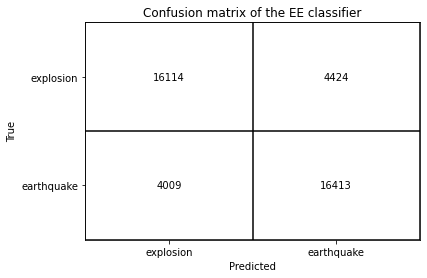

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[16114,  4424],
       [ 4009, 16413]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.80      0.78      0.79     20538
  earthquake       0.79      0.80      0.80     20422

    accuracy                           0.79     40960
   macro avg       0.79      0.79      0.79     40960
weighted avg       0.79      0.79      0.79     40960

Unsaved val eval:
1856 1218 80 174
['explosion', 'earthquake']
EE


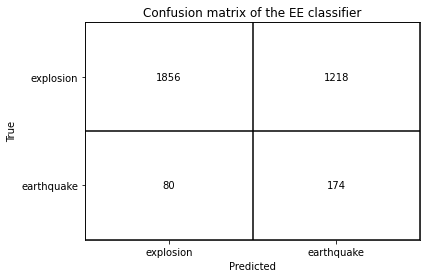

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1856, 1218],
       [  80,  174]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.96      0.60      0.74      3074
  earthquake       0.12      0.69      0.21       254

    accuracy                           0.61      3328
   macro avg       0.54      0.64      0.48      3328
weighted avg       0.90      0.61      0.70      3328

Unsaved test eval:
1169 721 59 99
['explosion', 'earthquake']
EE


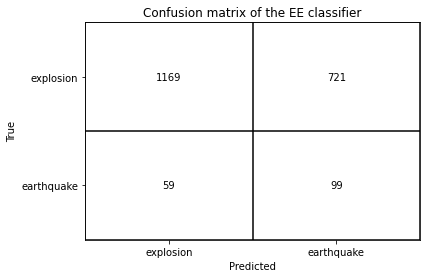

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1169,  721],
       [  59,   99]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.95      0.62      0.75      1890
  earthquake       0.12      0.63      0.20       158

    accuracy                           0.62      2048
   macro avg       0.54      0.62      0.48      2048
weighted avg       0.89      0.62      0.71      2048



In [4]:
use_tensorboard = True
use_liveplots = False
use_custom_callback = True
use_early_stopping = True
start_from_scratch = False
use_reduced_lr = True
log_data = True
beta = 2


params = {
        "batch_size" : 256,
        "epochs" : 50,
        "learning_rate" : 0.01,
        "optimizer" : "sgd",
        "num_layers" : 2,
        "units" : 320,
        "dropout_T_bn_F" : False,
        "use_layerwise_dropout_batchnorm" : True,
        "growth_sequence" : [1,2],
        "dropout_rate" : 0.001,
        "l2_r" : 0.001,
        "l1_r" : 0,
        "activation" : "relu",
        "output_layer_activation" : "sigmoid"
    }

workers = 32
max_queue_size = 20

finalModel = TrainSingleModelRam(noiseAug, helper, loadData,
                                 model_type, num_channels, use_tensorboard,
                                 use_liveplots, use_custom_callback, 
                                 use_early_stopping, use_reduced_lr, ramLoader,
                                 log_data = log_data,
                                 start_from_scratch = start_from_scratch, 
                                 beta = beta)
model = finalModel.run(x_train, y_train, x_val, y_val, x_test, y_test, workers, max_queue_size, evaluate_train = True, evaluate_val = True, evaluate_test = True, meier_mode = False, index = None, **params)

1849 1225 83 171


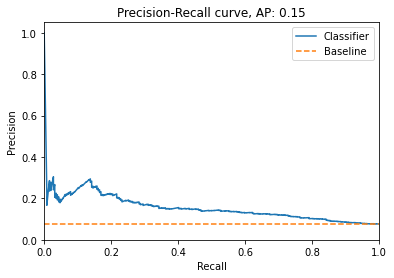

['explosion', 'earthquake']
EE


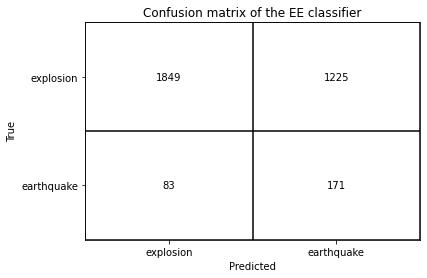

<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1849, 1225],
       [  83,  171]], dtype=int32)>
              precision    recall  f1-score   support

   explosion       0.96      0.60      0.74      3074
  earthquake       0.12      0.67      0.21       254

    accuracy                           0.61      3328
   macro avg       0.54      0.64      0.47      3328
weighted avg       0.89      0.61      0.70      3328



(<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
 array([[1849, 1225],
        [  83,  171]], dtype=int32)>,
 '              precision    recall  f1-score   support\n\n   explosion       0.96      0.60      0.74      3074\n  earthquake       0.12      0.67      0.21       254\n\n    accuracy                           0.61      3328\n   macro avg       0.54      0.64      0.47      3328\nweighted avg       0.89      0.61      0.70      3328\n',
 0.60697115384615385,
 0.122493,
 0.67322800000000005,
 0.35447800000000002)

In [5]:
helper.evaluate_generator(model, x_val, y_val, params["batch_size"], loadData.label_dict, num_channels, noiseAug, scaler_name, 2, plot_conf_matrix = True, plot_p_r_curve = True, beta = beta)

In [7]:
save_dir = '/media/tord/T7/Thesis_ssd/SavedModels/DENSE'
model_name = 'dense_EE_final'
model_path = f'{save_dir}/{model_name}'

#model.save(model_path)
#model = tf.keras.models.load_model(model_path)

INFO:tensorflow:Assets written to: /media/tord/T7/Thesis_ssd/SavedModels/DENSE/dense_EE_final/assets


In [6]:
y_predictions = helper.predict_generator()

AttributeError: 'HelperFunctions' object has no attribute 'predict_generator'